# 🧠 Linux Kernel Process Scheduler Visualizer

This project simulates and visualizes two major Linux CPU scheduling algorithms:

- **Round Robin (RR)**: Equal CPU time with time-slicing.
- **Completely Fair Scheduler (CFS)**: Distributes CPU time based on virtual runtime, favoring fairness.

We’ll compare how these algorithms schedule processes using:
- **Gantt charts**
- **Performance metrics**
- **Bar charts**
- **CSV export**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import heapq
import numpy as np


In [ ]:
# 📥 Define process table (can also load via CSV)
df = pd.DataFrame({
    "PID": ["P1", "P2", "P3", "P4"],
    "ArrivalTime": [0, 2, 4, 6],
    "BurstTime": [7, 4, 1, 4]
})
df


,PID,ArrivalTime,BurstTime
0,P1,0,7
1,P2,2,4
2,P3,4,1
3,P4,6,4


## 🔄 Round Robin Scheduler

- Uses **time slicing** (quantum).
- Each process gets equal CPU time in a circular queue.
- Suitable for time-sharing systems.

The function below implements RR scheduling.


In [ ]:
def round_robin_scheduler(df, quantum=2):
    time = 0
    queue = deque()
    remaining = df.set_index("PID")["BurstTime"].to_dict()
    arrival = df.set_index("PID")["ArrivalTime"].to_dict()
    gantt = []
    ready = set()
    completed = set()

    while len(completed) < len(df):
        for pid, at in arrival.items():
            if at <= time and pid not in queue and pid not in completed and pid not in ready:
                queue.append(pid)
                ready.add(pid)

        if queue:
            pid = queue.popleft()
            exec_time = min(quantum, remaining[pid])
            gantt.append((pid, time, time + exec_time))
            time += exec_time
            remaining[pid] -= exec_time

            if remaining[pid] == 0:
                completed.add(pid)
            else:
                for pid2, at in arrival.items():
                    if at <= time and pid2 not in queue and pid2 not in completed and pid2 not in ready:
                        queue.append(pid2)
                        ready.add(pid2)
                queue.append(pid)
        else:
            time += 1

    return gantt


## ⚖️ Completely Fair Scheduler (CFS)

- Based on **virtual runtime**.
- Processes that have used less CPU time are prioritized.
- Implements fairness by using a **min-heap**.

The function below simulates CFS.


In [ ]:
def cfs_scheduler(df):
    time = 0
    vruntime = {}
    remaining = df.set_index("PID")["BurstTime"].to_dict()
    arrival = df.set_index("PID")["ArrivalTime"].to_dict()
    gantt = []
    heap = []
    added_to_heap = set()

    while remaining:
        for pid, at in arrival.items():
            if at <= time and pid not in added_to_heap:
                vruntime[pid] = 0
                heapq.heappush(heap, (vruntime[pid], pid))
                added_to_heap.add(pid)

        if not heap:
            time += 1
            continue

        _, pid = heapq.heappop(heap)

        if pid not in remaining:
            continue  # Already completed

        gantt.append((pid, time, time + 1))
        time += 1
        remaining[pid] -= 1
        vruntime[pid] += 1

        if remaining[pid] > 0:
            heapq.heappush(heap, (vruntime[pid], pid))
        else:
            del remaining[pid]
            del vruntime[pid]

    return gantt


In [ ]:
def plot_gantt(gantt, title, filename=None):
    fig, ax = plt.subplots(figsize=(10, 2))
    for pid, start, end in gantt:
        ax.barh(0, end - start, left=start, height=0.5, edgecolor='black')
        ax.text((start + end)/2, 0, pid, ha='center', va='center', color='white')
    ax.set_yticks([])
    ax.set_xlabel("Time")
    ax.set_title(title)
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()


In [ ]:
def calculate_metrics(df, gantt):
    start_time = {}
    completion_time = {}

    for pid, start, end in gantt:
        if pid not in start_time:
            start_time[pid] = start
        completion_time[pid] = end

    metrics = []
    for _, row in df.iterrows():
        pid, at, bt = row["PID"], row["ArrivalTime"], row["BurstTime"]
        st = start_time[pid]
        ct = completion_time[pid]
        tat = ct - at
        wt = tat - bt
        rt = st - at
        metrics.append([pid, at, bt, st, ct, tat, wt, rt])

    return pd.DataFrame(metrics, columns=["PID", "AT", "BT", "ST", "CT", "TAT", "WT", "RT"])


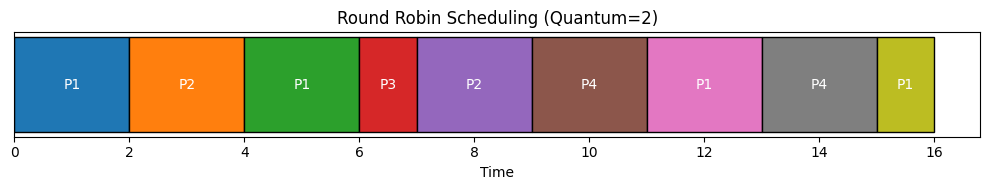

,PID,AT,BT,ST,CT,TAT,WT,RT
0,P1,0,7,0,16,16,9,0
1,P2,2,4,2,9,7,3,0
2,P3,4,1,6,7,3,2,2
3,P4,6,4,9,15,9,5,3


In [ ]:
rr_gantt = round_robin_scheduler(df, quantum=2)
plot_gantt(rr_gantt, "Round Robin Scheduling (Quantum=2)", "rr_gantt.png")
rr_metrics = calculate_metrics(df, rr_gantt)
rr_metrics


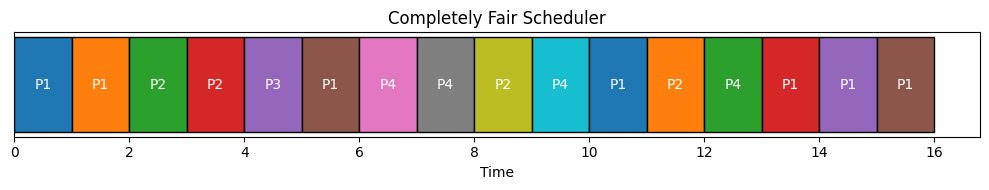

,PID,AT,BT,ST,CT,TAT,WT,RT
0,P1,0,7,0,16,16,9,0
1,P2,2,4,2,12,10,6,0
2,P3,4,1,4,5,1,0,0
3,P4,6,4,6,13,7,3,0


In [ ]:
cfs_gantt = cfs_scheduler(df)
plot_gantt(cfs_gantt, "Completely Fair Scheduler", "cfs_gantt.png")
cfs_metrics = calculate_metrics(df, cfs_gantt)
cfs_metrics


In [ ]:
summary = pd.DataFrame({
    "Scheduler": ["Round Robin", "CFS"],
    "Avg WT": [rr_metrics["WT"].mean(), cfs_metrics["WT"].mean()],
    "Avg TAT": [rr_metrics["TAT"].mean(), cfs_metrics["TAT"].mean()],
    "Avg RT": [rr_metrics["RT"].mean(), cfs_metrics["RT"].mean()]
})
summary


,Scheduler,Avg WT,Avg TAT,Avg RT
0,Round Robin,4.75,8.75,1.25
1,CFS,4.50,8.50,0.00


In [ ]:
rr_metrics.to_csv("round_robin_metrics.csv", index=False)
cfs_metrics.to_csv("cfs_metrics.csv", index=False)


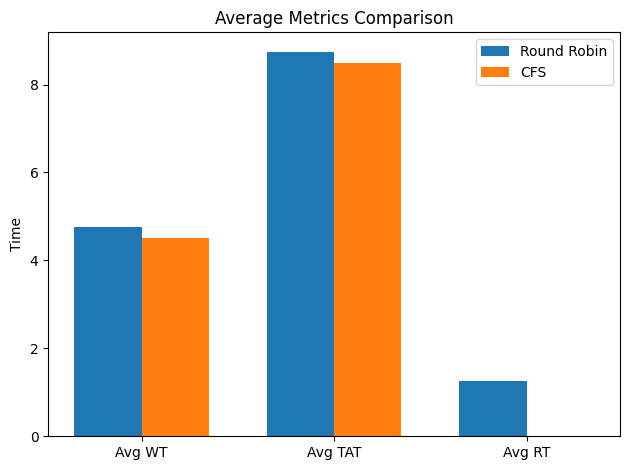

In [ ]:
labels = ['Avg WT', 'Avg TAT', 'Avg RT']
rr_scores = [rr_metrics["WT"].mean(), rr_metrics["TAT"].mean(), rr_metrics["RT"].mean()]
cfs_scores = [cfs_metrics["WT"].mean(), cfs_metrics["TAT"].mean(), cfs_metrics["RT"].mean()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rr_scores, width, label='Round Robin')
ax.bar(x + width/2, cfs_scores, width, label='CFS')

ax.set_ylabel('Time')
ax.set_title('Average Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.savefig("comparison_chart.png")
plt.show()


## ✅ Conclusion

- **Round Robin** gives equal CPU time but can cause high context switching.
- **CFS** offers fairness based on execution history.
- Gantt charts and metrics show how different algorithms behave on the same input.
- This tool is helpful for learning and analyzing real OS schedulers.
